In [37]:
import os
from datetime import datetime

from threading import Thread
import IPython
import IPython.display

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from profiling import cumTimer , simple_timer

In [38]:
print(tf.__version__)

2.6.0


In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

# Import Data

In [41]:
InputData = np.genfromtxt('Data/InputData.csv',delimiter=",")
t = np.genfromtxt('Data/time.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputData.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (1000, 100), 
InputData: (100, 4), 
Time: (1000,)


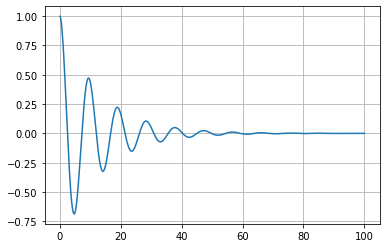

In [42]:
example_ind = 61
plt.plot(t,Data[:,example_ind])
plt.grid()

# Split The Data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

    It ensures that chopping the data into windows of consecutive samples is still possible.
    It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.


In [43]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


# Normalize Data

In [44]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

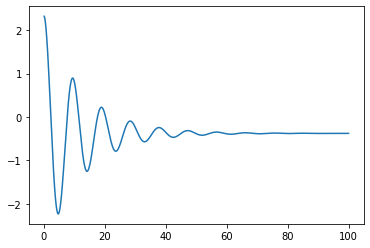

In [45]:
plt.plot(t,train_df[:,example_ind])


# Data Windowing

In [46]:
from window import WindowGenerator

make_dataset ran in: 0.3300669193267822 sec


Total window size: 45
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]

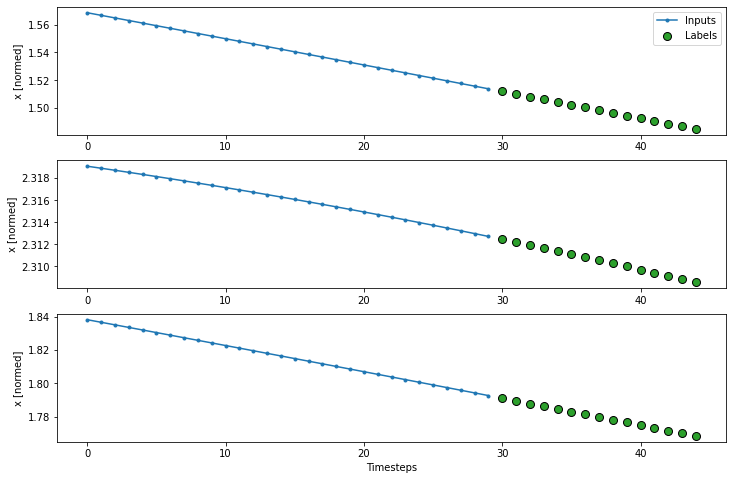

In [47]:
OUT_STEPS = 15
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df)

multi_window.plotexample()
multi_window

# FeedBack Model

In [48]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units

    self.l1 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM1")
    self.l2 = Dropout(0.2)
    self.l3 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM2")
    self.l4 = Dropout(0.2)
    self.l5 = Flatten(name = "Flat")
    self.l6 = Dense(units,activation=None, use_bias=True,name="Dense1")
    self.l7 = LeakyReLU(alpha=0.4,name = "LR3")
    self.l8 = Dense(units=1,name="Output")

In [49]:
@tf.function
def warmup(self, inputs):
  inp = inputs                                 #Input        => inputs.shape      => (batch, time, features)
  x, *carry_state1 = self.l1(inp)              #LSTM 1       => x.shape           => (batch, timesteps,lstm_units)
  x = self.l2(x)                               #LEAKY RELU 1 => x.shape           => (batch, timesteps,lstm_units)
  x, *carry_state2  = self.l3(x)               #LSTM_2       => x.shape           => (batch, timesteps,lstm_units)
  x = self.l4(x)                               #Leaky_ReLU_2 => x.shape           => (batch, timesteps,lstm_units)
  x = self.l5(x)                               #Flatten      => x.shape           => (batch, timesteps * lstm_units)
  x = self.l6(x)                               #Dense_1      => x.shape           => (batch, lstm_units)
  x = self.l7(x)                               #Leaky_ReLU_3 => x.shape           => (batch, lstm_units)
  prediction = self.l8(x)                      #Dense_2      => predictions.shape => (batch, 1)
  
  return prediction , carry_state1 ,carry_state2

FeedBack.warmup = warmup

In [50]:
feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

# Observe Shapes

In [51]:
prediction, *states = feedback_model.warmup(multi_window.example[0])
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', prediction.shape)

Input shape: (700, 30, 1)
Output shape: (700, 1)


# Define Model Call

In [52]:
@tf.function
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = inputs
  # Initialize the LSTM state.
  prediction, carry_state1, carry_state2 = self.warmup(inputs)
  # Insert the first prediction.
  predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast
  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    inp = predictions[:,n:,:]
    # Execute one lstm step.
    x, *carry_state1 = self.l1(inp , initial_state= [*carry_state1],
                                            training=training) #LSTM
    x = self.l2(x) #LEAKY RELU
    x, *carry_state2 = self.l3(x, initial_state= [*carry_state2], 
                                            training=training) #LSTM
    x = self.l4(x) #LEAKY RELU
    x = self.l5(x) #FLATEN
    x = self.l6(x) #DENSE/
    x = self.l7(x) #LEAKY RELU
    prediction = self.l8(x) #DENSELOL

    predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast

  # predictions.shape => (time, batch, features)
  return predictions[:,-OUT_STEPS:,:]

FeedBack.call = call

## Output Shape

In [53]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

call ran in: 7.431198596954346 sec
Output shape (batch, time, features):  (700, 15, 1)


## Plot Example

call ran in: 0.030913829803466797 sec
call ran in: 0.03167295455932617 sec
call ran in: 0.02671217918395996 sec


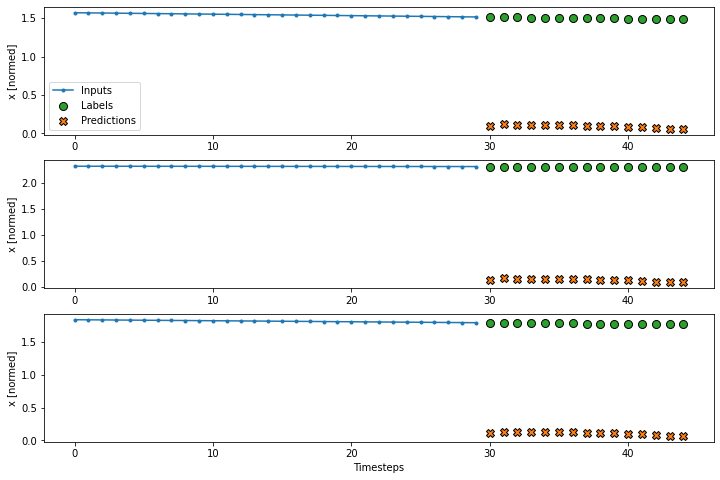

In [54]:
multi_window.plotexample(feedback_model)

## Plot Specific

call ran in: 7.5890796184539795 sec


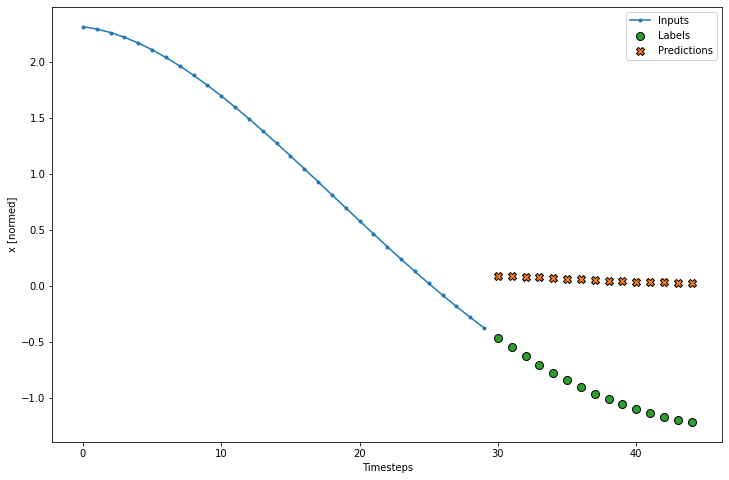

In [55]:
multi_window.plot(train_df[:,63],feedback_model)

# Compile And Fit Model

In [57]:
def compile_and_fit(model, name, window, patience=10, MAX_EPOCHS=500, record=False, load=None):
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H:%M")
    if load is not None:
        model.load_weights(f"Models/{load}")
        NAME = load + "AR@"+str(MAX_EPOCHS)+dt_string
    else:
        NAME = name + "@"+str(MAX_EPOCHS)+"@"+dt_string

    filename = os.path.join("Models",  NAME + '.h5')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    if record == True:
        tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                                     save_best_only=True, mode='min', save_weights_only=True)
        callbacks = [early_stopping, tensorboard, checkpoint]
    else:
        callbacks = [early_stopping]

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        batch_size=16,
                        callbacks=callbacks)
    return history


val_performance = {}
performance = {}


In [58]:
multi_val_performance = {}
multi_performance = {}

In [59]:
feedback_model.summary()

Model: "feed_back_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 multiple                  16896     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
LSTM2 (LSTM)                 multiple                  33024     
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
Flat (Flatten)               multiple                  0         
_________________________________________________________________
Dense1 (Dense)               multiple                  122944    
_________________________________________________________________
LR3 (LeakyReLU)              multiple                  

In [61]:
%%time
history = compile_and_fit(feedback_model,
                          name="LSTM_AR100_Dropout",
                          window =multi_window, 
                          patience =20, 
                          MAX_EPOCHS=50,
                          record = True,
                          load = "LSTM@500@09-01-2022-02:58.h5")

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)



make_dataset ran in: 0.16453790664672852 sec
 1/96 [..............................] - ETA: 17s - loss: 0.0124 - mean_absolute_error: 0.0552

96/96 [==============================] - 3s 26ms/step - loss: 0.0145 - mean_absolute_error: 0.0539
make_dataset ran in: 0.10855674743652344 sec
CPU times: user 14min 58s, sys: 3min 9s, total: 18min 8s
Wall time: 17min 1s


# Visualize Results

call ran in: 0.029451847076416016 sec
call ran in: 0.030811548233032227 sec
call ran in: 0.028748750686645508 sec


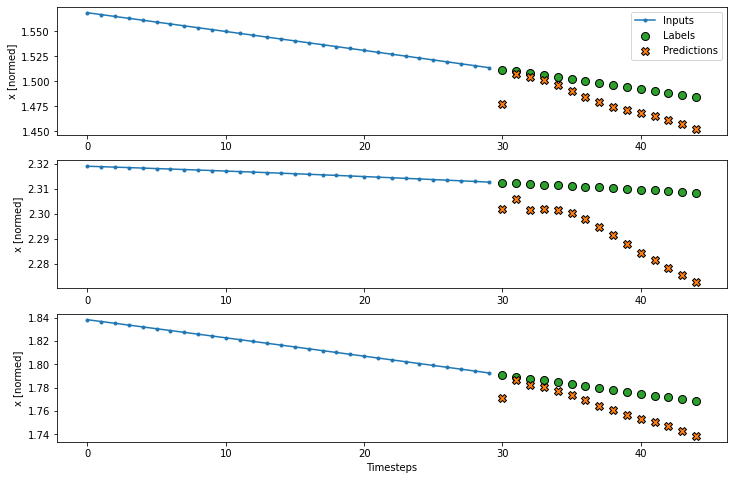

In [62]:
multi_window.plotexample(feedback_model)

W: 0.34
Z: 0.11888888888888888
X0: 1.0
V0: 0.0
call ran in: 0.02322840690612793 sec


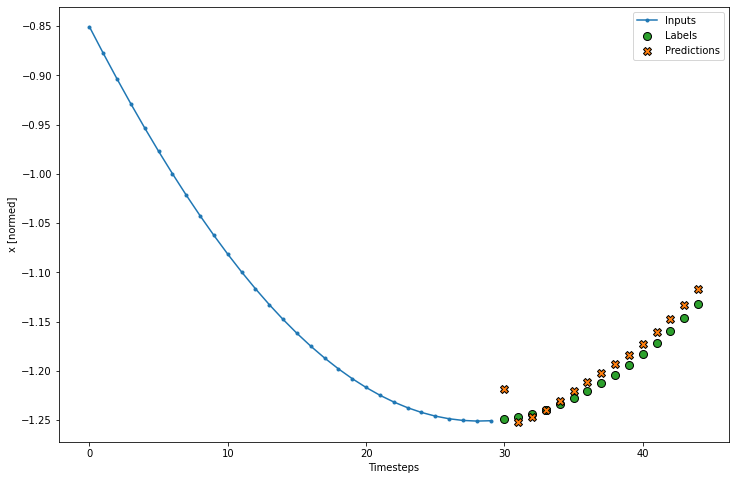

In [63]:
startTime = 250
exampleCase = 31
CaseParameters = InputData[exampleCase]
print("W: {}\nZ: {}\nX0: {}\nV0: {}".format(*CaseParameters))
multi_window.plot( inputs=train_df[startTime:startTime+multi_window.total_window_size, exampleCase], model=feedback_model)

In [64]:
feedback_model.save_weights("Models/feedbackWeights.h5")